# Import Dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd "/content/drive/Shared drives/MSDA Data 255 2023/Project Report/GITHUB_UPLOADS/SEMI_SUPERVISED_LEARNING"

/content/drive/Shared drives/MSDA Data 255 2023/Project Report/GITHUB_UPLOADS/SEMI_SUPERVISED_LEARNING


In [7]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras import layers

import warnings
warnings.filterwarnings("ignore")

In [8]:
df = pd.read_csv("mbti_labelled.csv")

In [14]:
%cd "/content/drive/Shared drives/MSDA Data 255 2023/Project Report/GITHUB_UPLOADS/SEMI_SUPERVISED_LEARNING"

/content/drive/Shared drives/MSDA Data 255 2023/Project Report/GITHUB_UPLOADS/SEMI_SUPERVISED_LEARNING


In [15]:

import pandas as pd
from sklearn.model_selection import train_test_split

# Perform stratified split with 50% of data in each set
train_df, test_df = train_test_split(df, test_size=0.5, stratify=df['type'], random_state=42)

# Save the datasets to CSV files
train_df.to_csv('/content/drive/Shared drives/MSDA Data 255 2023/Project Report/GITHUB_UPLOADS/SEMI_SUPERVISED_LEARNING/mbti_train.csv', index=False)
test_df.to_csv('/content/drive/Shared drives/MSDA Data 255 2023/Project Report/GITHUB_UPLOADS/SEMI_SUPERVISED_LEARNING/mbti_SGD_BiLSTM_test.csv', index=False)

print("Stratified split complete and CSV files saved.")

Stratified split complete and CSV files saved.


In [16]:
train_df

,type,posts
6319,INFP,everything you wrote made perfect sense except...
2625,INTJ,food cat computer cat i am not choosing one p...
6449,ENFJ,yes for some reason my signature isn t working...
1264,ENTP,you know you re a thinker when you love to wat...
1065,INFP,dear leictreon and lupusrex you guy ask reall...
...,...,...
2173,ENTJ,this thread need more post it s the best haha...
5199,INTP,really butthurt over something if you think i...
4587,ISFP,dear isfj mother i wish you were le of a work...
4172,ENTP,i m not much into dream analysis but this wa ...


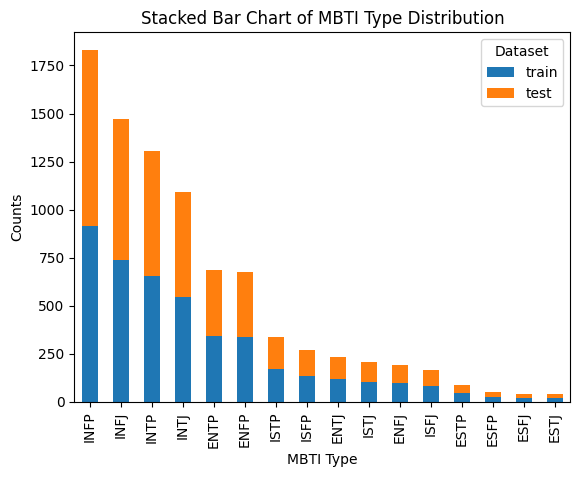

In [18]:
# Assuming df_train and df_test are already defined and are the result of the stratified split
# and contain a 'type' column with the MBTI types

# We would first need to get the counts of each MBTI type in both training and testing datasets
train_counts = train_df['type'].value_counts()
test_counts = test_df['type'].value_counts()

# Create a new DataFrame that contains the counts for both sets
stacked_df = pd.DataFrame({'train': train_counts, 'test': test_counts})

# Plot stacked bar chart
stacked_df.plot(kind='bar', stacked=True)

# Adding titles and labels
plt.title('Stacked Bar Chart of MBTI Type Distribution')
plt.xlabel('MBTI Type')
plt.ylabel('Counts')
plt.legend(title='Dataset')

# Display the plot
plt.show()


# Exploratory Data Analysis

In [19]:
df=train_df

In [20]:
df.head()

,type,posts
6319,INFP,everything you wrote made perfect sense except...
2625,INTJ,food cat computer cat i am not choosing one p...
6449,ENFJ,yes for some reason my signature isn t working...
1264,ENTP,you know you re a thinker when you love to wat...
1065,INFP,dear leictreon and lupusrex you guy ask reall...


In [21]:
# Check for number of rows and null values as well as datatype in data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4337 entries, 6319 to 5658
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    4337 non-null   object
 1   posts   4337 non-null   object
dtypes: object(2)
memory usage: 101.6+ KB


Count of column: type
INFP    916
INFJ    735
INTP    652
INTJ    545
ENTP    342
ENFP    337
ISTP    168
ISFP    135
ENTJ    116
ISTJ    103
ENFJ     95
ISFJ     83
ESTP     45
ESFP     24
ESFJ     21
ESTJ     20
Name: type, dtype: int64


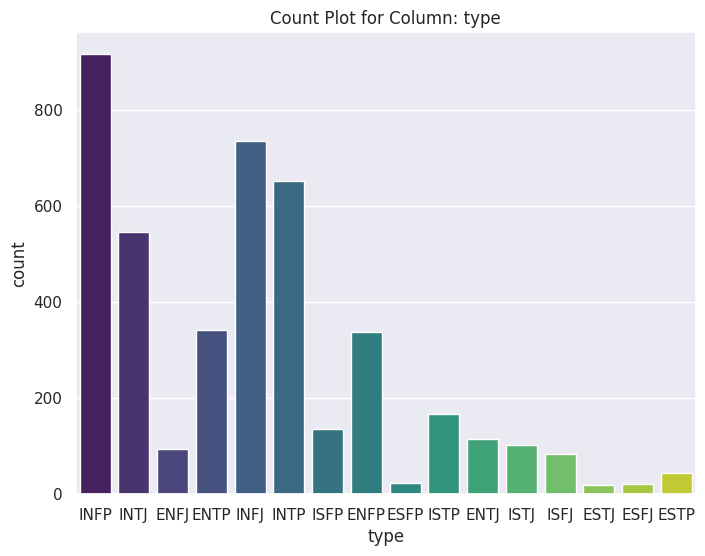

In [22]:
def count_plot(df_plot, column_name):
    sns.set(style="darkgrid")
    plt.figure(figsize=(8, 6))
    sns.countplot(x=column_name, data=df_plot, palette="viridis")
    plt.title(f'Count Plot for Column: {column_name}')
    print(f"Count of column: {column_name}")
    print("===============================")
    print(df_plot[column_name].value_counts())
    plt.show()


count_plot(df, "type")

We consider splitting the target into 4 different targets EI, SN, TF, JP and train 4 binary classifier for each. Since it is a binary classifier, the problem becomes much simpler and model's performance will be better.

# Data Processing

Splitting Target into 4

In [23]:
# Split type
df_split = df.copy()
df_split[["EI", "SN", "TF", "JP"]] = df["type"].apply(list).tolist()

In [24]:
df_split.head()

,type,posts,EI,SN,TF,JP
6319,INFP,everything you wrote made perfect sense except...,I,N,F,P
2625,INTJ,food cat computer cat i am not choosing one p...,I,N,T,J
6449,ENFJ,yes for some reason my signature isn t working...,E,N,F,J
1264,ENTP,you know you re a thinker when you love to wat...,E,N,T,P
1065,INFP,dear leictreon and lupusrex you guy ask reall...,I,N,F,P


### Countplot after split

Count of column: EI
I    3337
E    1000
Name: EI, dtype: int64


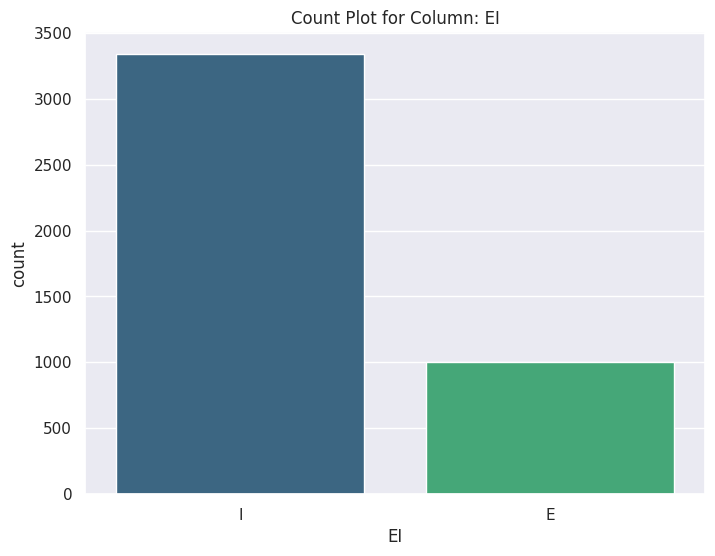

In [25]:
# EI
count_plot(df_split, "EI")

Count of column: SN
N    3738
S     599
Name: SN, dtype: int64


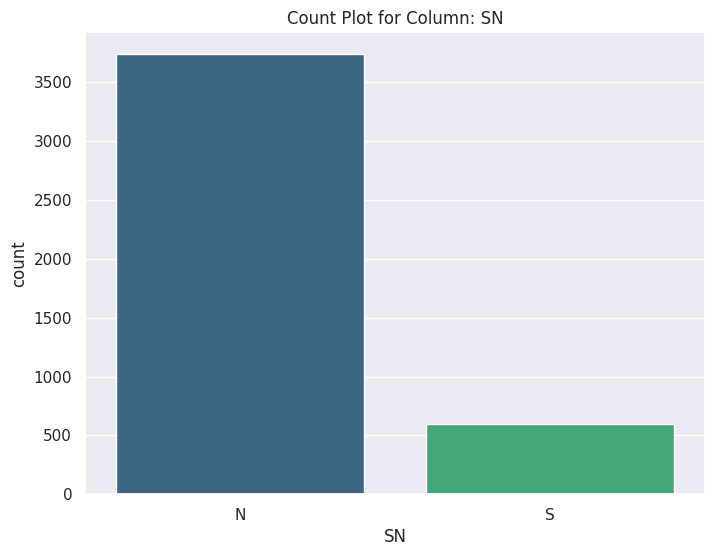

In [26]:
# SN
count_plot(df_split, "SN")

Count of column: TF
F    2346
T    1991
Name: TF, dtype: int64


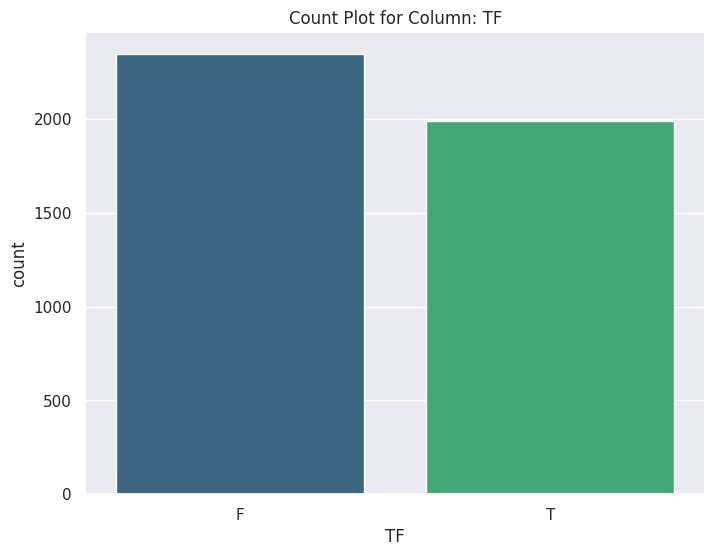

In [27]:
# TF
count_plot(df_split, "TF")

Count of column: JP
P    2619
J    1718
Name: JP, dtype: int64


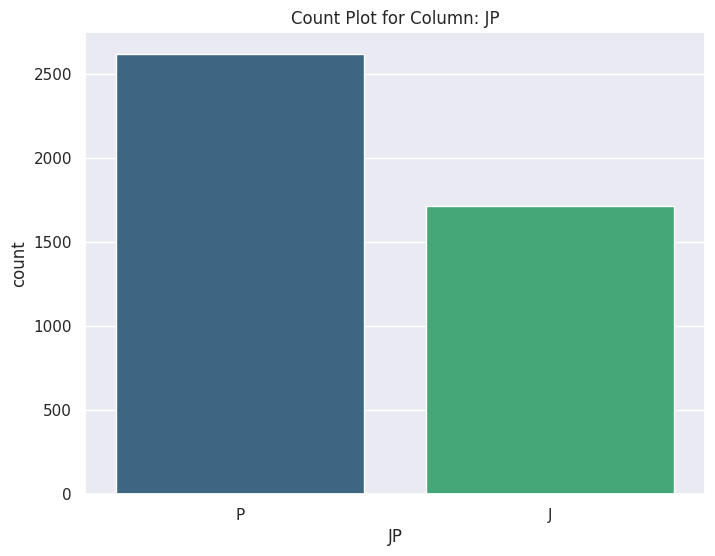

In [28]:
# JP
count_plot(df_split, "JP")

Since each dimension of the MBTI (EI, SN, TF, JP) are independent of each other, we can predict them separately.

In [30]:
# Count max words (Irrelevant for TFID)
def count_words(text):
    words = text.split()
    return len(words)

def count_max_words(df):
    word_counts = df['posts'].apply(count_words)
    max_row = df.loc[word_counts.idxmax()]
    max_word_count = count_words(max_row["posts"])
    return max_word_count

max_length = count_max_words(df_split)
print(max_length)

1951


In [53]:
# Load unlabelled data
unlabeled_df = pd.read_csv("sentiment140_unlabelled.csv")
unlabeled_df.head()

,type,posts
0,NaN,panera breads internet access is lame it block...
1,NaN,woke up like minutes ago its going to be a lon...
2,NaN,i dont wanna go skool i dont wanna take the fi...
3,NaN,actually dont go anymore cuz im a little sick ...
4,NaN,thats what everyone keeps saying but i wouldnt...


In [54]:
unlabeled_df = unlabeled_df.drop('type', axis=1)
unlabeled_df

,posts
0,panera breads internet access is lame it block...
1,woke up like minutes ago its going to be a lon...
2,i dont wanna go skool i dont wanna take the fi...
3,actually dont go anymore cuz im a little sick ...
4,thats what everyone keeps saying but i wouldnt...
...,...
21267,i just slammed my elbow into a fridge i did no...
21268,didnt get the dvd today either and she didnt a...
21269,you are right it is i love horror movies and h...
21270,aww you mean bigbird what is that site that ch...


In [55]:
df.head()

,type,posts
6319,INFP,everything you wrote made perfect sense except...
2625,INTJ,food cat computer cat i am not choosing one p...
6449,ENFJ,yes for some reason my signature isn t working...
1264,ENTP,you know you re a thinker when you love to wat...
1065,INFP,dear leictreon and lupusrex you guy ask reall...


Now both the labeled and unlabeled data's format are standardized

# Model Training: Semi-Supervised Learning

**Here we define our model pipeline. This code defines a scikit-learn pipeline for text classification. It first applies CountVectorizer to convert text data into a matrix of token counts, followed by TfidfTransformer to normalize the term frequencies. The classification is performed using a SelfTrainingClassifier, a custom classifier that employs a self-training approach with an underlying Stochastic Gradient Descent Classifier for iterative model improvement.**

In [56]:
# Define out model pipeline
def create_model():
  # Parameters
  sdg_params = dict(alpha=1e-5, penalty='l2', loss='log', class_weight='balanced')
  vectorizer_params = dict(ngram_range=(1, 2), min_df=5, max_df=0.8)

  # Supervised Pipeline
  pipeline = Pipeline([
      ('vect', CountVectorizer(**vectorizer_params)),
      ('tfidf', TfidfTransformer()),
      ('clf', SGDClassifier(**sdg_params)),
  ])

  # Semi supervised SelfTraining Pipeline
  st_pipeline = Pipeline([
      ('vect', CountVectorizer(**vectorizer_params)),
      ('tfidf', TfidfTransformer()),
      ('clf', SelfTrainingClassifier(SGDClassifier(**sdg_params), verbose=True)),
  ])

  return pipeline, st_pipeline

In [57]:
# Define a function to train and evaluate the trained models
def eval_and_print_metrics(clf, X_train, y_train, X_test, y_test):
    print("Number of training samples:", len(X_train))
    print("Unlabeled samples in training set:",
          sum(1 for x in y_train if x == -1))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Micro-averaged F1 score on test set: "
          "%0.3f" % f1_score(y_test, y_pred, average='micro'))
    print("-" * 10)
    print()

In [58]:
# Split the data and call the training, evaluation, comparison between supervised learning  and semisupervised learning
def ssl_train_tfid(pipeline, st_pipeline, df_labeled, df_combined, column_name):

    X, y = df_labeled.posts, df_labeled[column_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    print("Supervised SGDClassifier on labeled data:")
    eval_and_print_metrics(pipeline, X_train, y_train, X_test, y_test)

    print(classification_report(y_test, pipeline.predict(X_test)))


    # Prepare data here
    X, y = df_combined.posts, df_combined[column_name]
    x_train_unlabeled, _, y_train_unlabeled, _ = train_test_split(X, y, test_size=0.2, random_state=42)

    # With Self Training Classifier
    print("SelfTrainingClassifier on semi-labeled training data:")
    eval_and_print_metrics(st_pipeline, x_train_unlabeled, y_train_unlabeled, X_test, y_test)

    print(classification_report(y_test, st_pipeline.predict(X_test)))

    return st_pipeline

The SelfTrainingClassifier requires the labaled and unlabeled dataset to be combined as one dataframe, the value of the unlabeled rows should be -1.

In [59]:
# Combine dfs
def combine_df(df_split, df_unlabeled, column_name):
  df_split_temp = df_split[["posts", column_name]]
  df_unlabeled[column_name] = -1
  return pd.concat([df_split_temp, df_unlabeled], ignore_index=True)

Encode the labels as numerical values.

In [60]:
def label_encoding(df_labeled, column_name):
    label_encoder = LabelEncoder()
    df_labeled[column_name] = label_encoder.fit_transform(df_labeled[column_name])

    # Print the mapping between original labels and encoded values
    label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
    print("Label Mapping:")
    for label, encoded_value in label_mapping.items():
        print(f"{label}: {encoded_value}")
    return df_labeled

    df_split_encoded = label_encoding(df_split, "EI")

### Start Training

In [61]:
# Training EI
df_split_encoded = label_encoding(df_split, "EI")
df_EI = combine_df(df_split_encoded, unlabeled_df, "EI")
pipeline, st_pipeline = create_model()
Model_EI = ssl_train_tfid(pipeline, st_pipeline, df_split, df_EI, "EI")

Label Mapping:
0: 0
1: 1
Supervised SGDClassifier on labeled data:
Number of training samples: 3252
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.834
----------

              precision    recall  f1-score   support

           0       0.79      0.47      0.59       274
           1       0.84      0.96      0.90       811

    accuracy                           0.83      1085
   macro avg       0.81      0.71      0.74      1085
weighted avg       0.83      0.83      0.82      1085

SelfTrainingClassifier on semi-labeled training data:
Number of training samples: 20487
Unlabeled samples in training set: 17033
End of iteration 1, added 9357 new labels.
End of iteration 2, added 7673 new labels.
End of iteration 3, added 3 new labels.
Micro-averaged F1 score on test set: 0.899
----------

              precision    recall  f1-score   support

           0       0.72      0.97      0.83       274
           1       0.99      0.87      0.93       811

    acc

In [62]:
# Training SN
df_split_encoded = label_encoding(df_split, "SN")
df_SN = combine_df(df_split_encoded, unlabeled_df, "SN")
pipeline, st_pipeline = create_model()
Model_SN = ssl_train_tfid(pipeline, st_pipeline, df_split, df_SN, "SN")

Label Mapping:
0: 0
1: 1
Supervised SGDClassifier on labeled data:
Number of training samples: 3252
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.900
----------

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       940
           1       0.76      0.37      0.50       145

    accuracy                           0.90      1085
   macro avg       0.84      0.68      0.72      1085
weighted avg       0.89      0.90      0.89      1085

SelfTrainingClassifier on semi-labeled training data:
Number of training samples: 20487
Unlabeled samples in training set: 17033
End of iteration 1, added 2954 new labels.
End of iteration 2, added 8602 new labels.
End of iteration 3, added 3824 new labels.
End of iteration 4, added 804 new labels.
End of iteration 5, added 192 new labels.
End of iteration 6, added 111 new labels.
End of iteration 7, added 27 new labels.
End of iteration 8, added 10 new labels.
End of iteratio

In [63]:
# Training TF
df_split_encoded = label_encoding(df_split, "TF")
df_TF = combine_df(df_split_encoded, unlabeled_df, "TF")
pipeline, st_pipeline = create_model()
Model_TF = ssl_train_tfid(pipeline, st_pipeline, df_split, df_TF, "TF")

Label Mapping:
0: 0
1: 1
Supervised SGDClassifier on labeled data:
Number of training samples: 3252
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.847
----------

              precision    recall  f1-score   support

           0       0.88      0.83      0.85       585
           1       0.81      0.87      0.84       500

    accuracy                           0.85      1085
   macro avg       0.85      0.85      0.85      1085
weighted avg       0.85      0.85      0.85      1085

SelfTrainingClassifier on semi-labeled training data:
Number of training samples: 20487
Unlabeled samples in training set: 17033
End of iteration 1, added 3404 new labels.
End of iteration 2, added 5954 new labels.
End of iteration 3, added 2584 new labels.
End of iteration 4, added 940 new labels.
End of iteration 5, added 231 new labels.
End of iteration 6, added 127 new labels.
End of iteration 7, added 83 new labels.
End of iteration 8, added 59 new labels.
End of iteratio

In [64]:
# Training JP
df_split_encoded = label_encoding(df_split, "JP")
df_JP = combine_df(df_split_encoded, unlabeled_df, "JP")
pipeline, st_pipeline = create_model()
Model_JP = ssl_train_tfid(pipeline, st_pipeline, df_split, df_JP, "JP")

Label Mapping:
0: 0
1: 1
Supervised SGDClassifier on labeled data:
Number of training samples: 3252
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.757
----------

              precision    recall  f1-score   support

           0       0.74      0.60      0.66       434
           1       0.76      0.86      0.81       651

    accuracy                           0.76      1085
   macro avg       0.75      0.73      0.74      1085
weighted avg       0.76      0.76      0.75      1085

SelfTrainingClassifier on semi-labeled training data:
Number of training samples: 20487
Unlabeled samples in training set: 17033
End of iteration 1, added 7371 new labels.
End of iteration 2, added 9662 new labels.
Micro-averaged F1 score on test set: 0.849
----------

              precision    recall  f1-score   support

           0       0.74      0.96      0.84       434
           1       0.97      0.77      0.86       651

    accuracy                           0.85    

**Interpretation: For each model's training, there will be two evaluation, first one is before semi-supervised learning, the second one after semi-supervised learning, both using the test set with laballed data. We can also see how many labels have been added into training. As we can see above, all 4 models have improved f1-score and accuracy after using semi-supervised learning. This means the models have captured more complex features from the unlabelled data and were able to achieve higher accuracy. This indicates that the semi-supervised learning is successful.**

# Data Imputation with trained models

In [66]:
unlabeled_df.head()

,posts,EI,SN,TF,JP
0,panera breads internet access is lame it block...,-1,-1,-1,-1
1,woke up like minutes ago its going to be a lon...,-1,-1,-1,-1
2,i dont wanna go skool i dont wanna take the fi...,-1,-1,-1,-1
3,actually dont go anymore cuz im a little sick ...,-1,-1,-1,-1
4,thats what everyone keeps saying but i wouldnt...,-1,-1,-1,-1


 **We will use the trained models from above and impute the labels if the prediction probability is above 80%, which means it is confident in it's prediction.
- Higher Threshold will produce less data but more reliability.
- Lower Threshold will produce more data but less reliability.**

In [67]:
# Imputing one by one with threshold probability of more than 80%
targets = ["EI", "SN", "TF", "JP"]
models = [Model_EI, Model_SN, Model_TF, Model_JP]

for i, target in enumerate(targets):
  prediction_probability = models[i].predict_proba(unlabeled_df["posts"])

  threshold = 0.80

  # Find the indices where the maximum probability is greater than the threshold
  indices_above_threshold = np.max(prediction_probability, axis=1) > threshold

  # Initialize an array for labels, set to NaN initially
  labels = np.full(prediction_probability.shape[0], np.nan)

  # Assign labels where the condition is met
  labels[indices_above_threshold] = np.argmax(prediction_probability, axis=1)[indices_above_threshold]

  unlabeled_df[target] = labels


Decoding the model's prediction back to our labels based. The label encoding can be found above in the training section.

In [68]:
# Decoding
# E - 0, I - 1
# N - 0, S - 1
# F - 0, T - 1
# J - 0, P - 1

unlabeled_df['EI'] = unlabeled_df['EI'].map({1.0: 'I', 0.0: 'E'})
unlabeled_df['SN'] = unlabeled_df['SN'].map({1.0: 'S', 0.0: 'N'})
unlabeled_df['TF'] = unlabeled_df['TF'].map({1.0: 'T', 0.0: 'F'})
unlabeled_df['JP'] = unlabeled_df['JP'].map({1.0: 'P', 0.0: 'J'})

In [69]:
# Count occurrences of S and N
print("======================")
print("SN")
count_0 = np.sum(unlabeled_df["SN"] == 'S')
count_1 = np.sum(unlabeled_df["SN"] == 'N')

# Print the results
print("Number of Ss:", count_0)
print("Number of Ns:", count_1)

SN
Number of Ss: 470
Number of Ns: 20013


In [70]:
unlabeled_df

,posts,EI,SN,TF,JP
0,panera breads internet access is lame it block...,I,N,NaN,P
1,woke up like minutes ago its going to be a lon...,I,N,NaN,P
2,i dont wanna go skool i dont wanna take the fi...,I,S,F,P
3,actually dont go anymore cuz im a little sick ...,I,N,F,P
4,thats what everyone keeps saying but i wouldnt...,I,N,NaN,P
...,...,...,...,...,...
21267,i just slammed my elbow into a fridge i did no...,I,N,F,P
21268,didnt get the dvd today either and she didnt a...,I,N,F,P
21269,you are right it is i love horror movies and h...,I,N,T,P
21270,aww you mean bigbird what is that site that ch...,I,N,NaN,P


There will be null values in the labels which we will remove from the final dataset because the model's prediction probability was low which means it is not confident/unsure of the label.

In [71]:
total_rows_with_null_values = unlabeled_df.isnull().any(axis=1).sum()
print("Total number of rows with null values:", total_rows_with_null_values)

Total number of rows with null values: 5683


In [72]:
# Remove rows with null values
rows_before_removal = len(unlabeled_df)
unlabeled_df_filtered = unlabeled_df.dropna()

rows_after_removal = len(unlabeled_df_filtered)
rows_removed = rows_before_removal - rows_after_removal

print("Number of rows removed:", rows_removed)
print("Cleaned DataFrame:")
print(unlabeled_df_filtered)

Number of rows removed: 5683
Cleaned DataFrame:
                                                   posts EI SN TF JP
2      i dont wanna go skool i dont wanna take the fi...  I  S  F  P
3      actually dont go anymore cuz im a little sick ...  I  N  F  P
5      last day in e lansing with the girls amp last ...  I  N  F  P
7      totally jealous i want to be at that party fee...  I  N  F  P
8      blackout i need a sleep just finished the quot...  I  N  F  P
...                                                  ... .. .. .. ..
21265  see whats so complicated bout this i wonder do...  I  N  T  P
21266  i think i should go outdoors more often i miss...  I  N  T  P
21267  i just slammed my elbow into a fridge i did no...  I  N  F  P
21268  didnt get the dvd today either and she didnt a...  I  N  F  P
21269  you are right it is i love horror movies and h...  I  N  T  P

[15589 rows x 5 columns]


Now we just concatenate the columns

In [73]:
# Concatenate types
unlabeled_df_filtered["type"] = unlabeled_df_filtered["EI"] + unlabeled_df_filtered["SN"] + unlabeled_df_filtered["TF"] + unlabeled_df_filtered["JP"]
unlabeled_df_filtered

,posts,EI,SN,TF,JP,type
2,i dont wanna go skool i dont wanna take the fi...,I,S,F,P,ISFP
3,actually dont go anymore cuz im a little sick ...,I,N,F,P,INFP
5,last day in e lansing with the girls amp last ...,I,N,F,P,INFP
7,totally jealous i want to be at that party fee...,I,N,F,P,INFP
8,blackout i need a sleep just finished the quot...,I,N,F,P,INFP
...,...,...,...,...,...,...
21265,see whats so complicated bout this i wonder do...,I,N,T,P,INTP
21266,i think i should go outdoors more often i miss...,I,N,T,P,INTP
21267,i just slammed my elbow into a fridge i did no...,I,N,F,P,INFP
21268,didnt get the dvd today either and she didnt a...,I,N,F,P,INFP


In [74]:
unlabeled_df_cleaned = unlabeled_df_filtered[["type", "posts"]]
unlabeled_df_cleaned

,type,posts
2,ISFP,i dont wanna go skool i dont wanna take the fi...
3,INFP,actually dont go anymore cuz im a little sick ...
5,INFP,last day in e lansing with the girls amp last ...
7,INFP,totally jealous i want to be at that party fee...
8,INFP,blackout i need a sleep just finished the quot...
...,...,...
21265,INTP,see whats so complicated bout this i wonder do...
21266,INTP,i think i should go outdoors more often i miss...
21267,INFP,i just slammed my elbow into a fridge i did no...
21268,INFP,didnt get the dvd today either and she didnt a...


### Save our dataset

In [76]:
# Save unlabelled dataframe into csv file
unlabeled_df_cleaned.to_csv('sentiment140_labelled.csv', index=False) # Change path accordingly

In [77]:
# Combine both labelled and extended dataset
import pandas as pd
labelled_dataset = pd.read_csv("mbti_train.csv")
extended_dataset = pd.read_csv("sentiment140_labelled.csv")

In [78]:
full_dataset = pd.concat([labelled_dataset, extended_dataset])

In [79]:
print(f"Original number of labelled data: {len(labelled_dataset)}")
print(f"Number of labelled data after Semi-supervised learning: {len(full_dataset)}")
print(f"Number of labels added: {len(full_dataset) - len(labelled_dataset)}")

Original number of labelled data: 4337
Number of labelled data after Semi-supervised learning: 19926
Number of labels added: 15589


# **TESTING THE SEMISUPERVISED TRAINED MODEL ON COMPLETELY UNSEEN DATASET TO INFER THE QUALITY OF LABELS GENERATED BY USING A SIMPLE LINEAR CLASSIFIER**

NOTE: The same dataset is used to test our Deep learning BiLSTM model also

In [80]:
df_test = pd.read_csv("mbti_SGD_BiLSTM_test.csv")

In [83]:
# Split type
df_test_split = df_test.copy()
df_test_split[["EI", "SN", "TF", "JP"]] = df_test_split["type"].apply(list).tolist()

In [84]:
X_test_split=df_test_split['EI']
Y_test_split=df_test_split['type']

In [85]:
# Define a function to train and evaluate the trained models
def eval_and_print_metrics_test(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    print("Micro-averaged F1 score on test set: "
          "%0.3f" % f1_score(y_test, y_pred, average='micro'))
    print("-" * 10)

In [89]:
from sklearn.metrics import classification_report, confusion_matrix

# Modify the function to return accuracy, precision, F1-score, recall, and confusion matrix
def ssl_train_tfid_new(pipeline, st_pipeline, df_split_encoded, df_test_split, column_name):

    X_train = df_split_encoded.posts  # Assuming df_labeled contains your labeled data
    y_train = df_split_encoded[column_name]
    X_test_split = df_test_split.posts
    Y_test_split = df_test_split[column_name]

    # Train the supervised model and make predictions
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test_split)

    # Calculate and print classification report
    class_report = classification_report(Y_test_split, y_pred, output_dict=True)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(Y_test_split, y_pred)

    # Extract the metrics you want (accuracy, precision, F1-score, and recall)
    accuracy = class_report['accuracy']
    precision = class_report['weighted avg']['precision']
    f1 = class_report['weighted avg']['f1-score']
    recall = class_report['weighted avg']['recall']

    # Print the metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("F1 Score:", f1)
    print("Recall:", recall)

    # Return both the metrics as a dictionary, the complete classification report, and the confusion matrix
    return {
        'metrics': {
            'accuracy': accuracy,
            'precision': precision,
            'f1_score': f1,
            'recall': recall,
        }
    }


In [ ]:
def label_encoding_test(df_labeled, column_name):
    label_encoder = LabelEncoder()
    df_test_split[column_name] = label_encoder.fit_transform(df_test_split[column_name])

    # Print the mapping between original labels and encoded values
    label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
    print("Label Mapping:")
    for label, encoded_value in label_mapping.items():
        print(f"{label}: {encoded_value}")
    return df_test_split

In [86]:
df_split_test_encoded = label_encoding(df_test_split, "EI")

Label Mapping:
E: 0
I: 1


In [87]:
ssl_train_tfid(pipeline, st_pipeline, df_split, df_split_test_encoded, 'EI')

Supervised SGDClassifier on labeled data:
Number of training samples: 3252
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.865
----------

              precision    recall  f1-score   support

           0       0.73      0.57      0.64       230
           1       0.89      0.94      0.92       855

    accuracy                           0.86      1085
   macro avg       0.81      0.76      0.78      1085
weighted avg       0.86      0.86      0.86      1085

SelfTrainingClassifier on semi-labeled training data:
Number of training samples: 3470
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.877
----------

              precision    recall  f1-score   support

           0       0.79      0.57      0.66       230
           1       0.89      0.96      0.93       855

    accuracy                           0.88      1085
   macro avg       0.84      0.76      0.79      1085
weighted avg       0.87      0.88      0.87      1085



Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.8, min_df=5, ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 SelfTrainingClassifier(base_estimator=SGDClassifier(alpha=1e-05,
                                                                     class_weight='balanced',
                                                                     loss='log'),
                                        verbose=True))])

In [91]:
df_split_test_encoded_EI = label_encoding(df_test_split, "EI")
df_split_test_encoded_SN = label_encoding(df_test_split, "SN")
df_split_test_encoded_TF = label_encoding(df_test_split, "TF")
df_split_test_encoded_JP = label_encoding(df_test_split, "JP")

Label Mapping:
0: 0
1: 1
Label Mapping:
N: 0
S: 1
Label Mapping:
F: 0
T: 1
Label Mapping:
J: 0
P: 1


In [96]:
ssl_train_tfid_new(pipeline, st_pipeline, df_split, df_split_test_encoded_EI, 'EI')

Accuracy: 0.8584601198709082
Precision: 0.8514206394487214
F1 Score: 0.8511819896567966
Recall: 0.8584601198709082


{'metrics': {'accuracy': 0.8584601198709082,
  'precision': 0.8514206394487214,
  'f1_score': 0.8511819896567966,
  'recall': 0.8584601198709082}}

In [97]:
ssl_train_tfid_new(pipeline, st_pipeline, df_split, df_split_test_encoded_SN, 'SN')

Accuracy: 0.9013370216689719
Precision: 0.8918493216470696
F1 Score: 0.8884198947015192
Recall: 0.9013370216689719


{'metrics': {'accuracy': 0.9013370216689719,
  'precision': 0.8918493216470696,
  'f1_score': 0.8884198947015192,
  'recall': 0.9013370216689719}}

In [98]:
ssl_train_tfid(pipeline, st_pipeline, df_split, df_split_test_encoded_TF, 'TF')

Accuracy: 0.851083448593822
Precision: 0.8528392853768496
F1 Score: 0.8513101380397199
Recall: 0.851083448593822


{'metrics': {'accuracy': 0.851083448593822,
  'precision': 0.8528392853768496,
  'f1_score': 0.8513101380397199,
  'recall': 0.851083448593822}}

In [99]:
ssl_train_tfid(pipeline, st_pipeline, df_split, df_split_test_encoded_JP, 'JP')

Accuracy: 0.7923005993545412
Precision: 0.792321571518818
F1 Score: 0.7923110424719668
Recall: 0.7923005993545412


{'metrics': {'accuracy': 0.7923005993545412,
  'precision': 0.792321571518818,
  'f1_score': 0.7923110424719668,
  'recall': 0.7923005993545412}}

----